In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
from torchvision import models
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import itertools
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# font = {'weight' : 'bold',
#         'size'   : 90}

# plt.rc('font', **font)

In [2]:
batch_size = 32
IMG_SIZE = [224,224]
num_classes = 42
device = "cuda"
target_names = [str(i) for i in range(42)]

In [3]:
transform = transforms.Compose(
    [transforms.Resize(IMG_SIZE),
     transforms.ToTensor(),
     transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

trainvalset = torchvision.datasets.ImageFolder("train/train/",transform=transform)
print(len(trainvalset))

trainset, valset = torch.utils.data.random_split(trainvalset, [len(trainvalset)-30000, 30000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.ImageFolder("test/",transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=1)

105392


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([14, 40,  7, 21, 25, 11, 41, 21,  8,  8, 32, 15, 34,  8,  9, 22, 12, 14,
         1, 25, 14,  0,  5, 25,  3, 26, 26, 22,  3, 32,  5, 31])


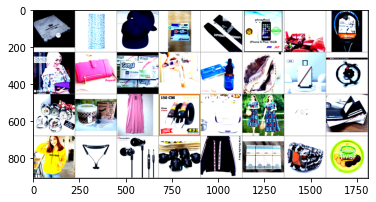

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(labels)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:

#model = models.resnet18(pretrained=True)
# model = torchvision.models.wide_resnet101_2(pretrained=True)
model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x16d_wsl')
#print(model)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
#model.load_state_dict(torch.load("wide_resnet101.pth"))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
print(model)



Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_master
Downloading: "https://download.pytorch.org/models/ig_resnext101_32x16-c6f796b0.pth" to /root/.cache/torch/checkpoints/ig_resnext101_32x16-c6f796b0.pth
Widget Javascript not detected.  It may not be installed or enabled properly.


In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(80, 60))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    #plt.rc('xtick', labelsize=20) 
    #plt.rc('ytick', labelsize=20) 

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45,fontsize=50)
        plt.yticks(tick_marks, target_names,fontsize=50)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
def evaluate(net):
    net.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        pbar = tqdm(valloader)
        i_batch = 0
        for data in pbar:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            
            for output,label in zip(predicted,labels):
                y_pred.append(output.item())
                y_true.append(label.item())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pbar.set_description("Val Accuracy %.2f" % (correct/float(total)))
            i_batch+=1
#             if(i_batch==10):
#                 break

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))
    
    cm = confusion_matrix(y_true, y_pred)
    
    plot_confusion_matrix(cm= cm, 
                      normalize    = True,
                      target_names = target_names,
                      title        = "Confusion Matrix")

In [ ]:
print("Started Training")
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0
        #if i % 200 == 199:
    evaluate(model)
    model.train()
    torch.save(model.state_dict(), "wide_resnet101.pth")

print('Finished Training')